#loan repayment  Approval

# Predicting whether an applicant is capable of repaying a loan

As a bank decides which applicants to provide loans, they may wish to predict if the applicant will default on the loan. Through automated feature engineering, we can identify the predictive patterns in the financial data that can be used to ensure that clients capable of repayment are not rejected.

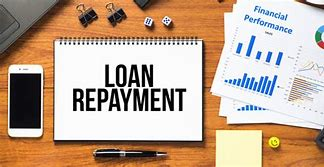

Introduction

The two most critical questions in the lending industry are: 1) How risky is the borrower? 2) Given the borrower’s risk, should we lend him/her? The answer to the first question determines the interest rate the borrower would have. Interest rate measures among other things (such as time value of money) the riskness of the borrower, i.e. the riskier the borrower, the higher the interest rate. With interest rate in mind, we can then determine if the borrower is eligible for the loan.

Investors (lenders) provide loans to borrowers in exchange for the promise of repayment with interest. That means the lender only makes profit (interest) if the borrower pays off the loan. However, if he/she doesn’t repay the loan, then the lender loses money.

We’ll be using publicly available data from LendingClub.com. The data covers the 9,578 loans funded by the platform between May 2007 and February 2010. The interest rate is provided to us for each borrower. Therefore, so we’ll address the second question indirectly by trying to predict if the borrower will repay the loan by its mature date or not.

Below is a short description of each feature in the data set:

credit_policy:
1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.

purpose:
The purpose of the loan such as: credit_card, debt_consolidation, etc.

int_rate: 
The interest rate of the loan (proportion).

installment:
The monthly installments ($) owed by the borrower if the loan is funded.

log_annual_inc:
The natural log of the annual income of the borrower.


dti: The debt-to-income ratio of the borrower.


fico: The FICO credit score of the borrower.


days_with_cr_line: The number of days the borrower has had a credit line.


revol_bal: The borrower’s revolving balance.


revol_util: The borrower’s revolving line utilization rate.


inq_last_6mths: The borrower’s number of inquiries by creditors in the last 6 months.


delinq_2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.


pub_rec: The borrower’s number of derogatory public records.


not_fully_paid: indicates whether the loan was not paid back in full (the borrower either defaulted or the borrower was deemed unlikely to pay it back).

In [249]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import  RobustScaler, FunctionTransformer,StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score)
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from keras import models, layers, optimizers
from tensorflow import keras

In [177]:
df=pd.read_csv('/content/loan_data.csv')
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [179]:
df.shape

(9578, 14)

In [180]:
df.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


In [181]:
df.columns.isna().sum()

0

In [182]:
df['days.with.cr.line'].isna().sum()	

0

In [183]:
df['not.fully.paid'].value_counts()

0    8045
1    1533
Name: not.fully.paid, dtype: int64

<Axes: xlabel='not.fully.paid', ylabel='count'>

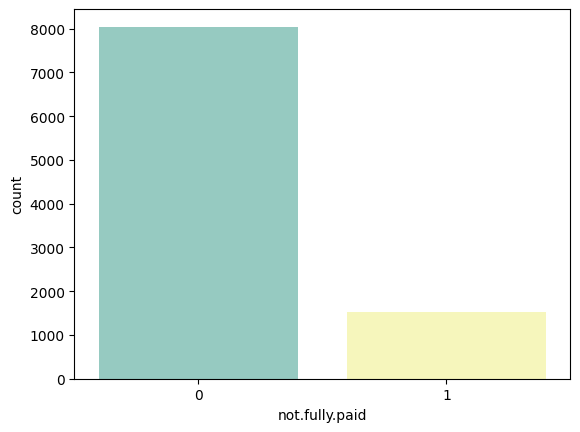

In [184]:
sns.countplot(x='not.fully.paid',data=df)

In [185]:
paid=df[df['not.fully.paid']==0]
not_paid=df[df['not.fully.paid']==1]


In [186]:
len(paid)

8045

In [187]:
len(not_paid)

1533

In [188]:
paid_per=round((len(paid)/df['not.fully.paid'].count()*100),2)
not_paid_per=round((len(not_paid)/df['not.fully.paid'].count()*100),2)

      Class  Percentage
0      paid       83.99
1  not-paid       16.01


<Axes: xlabel='Class', ylabel='Percentage'>

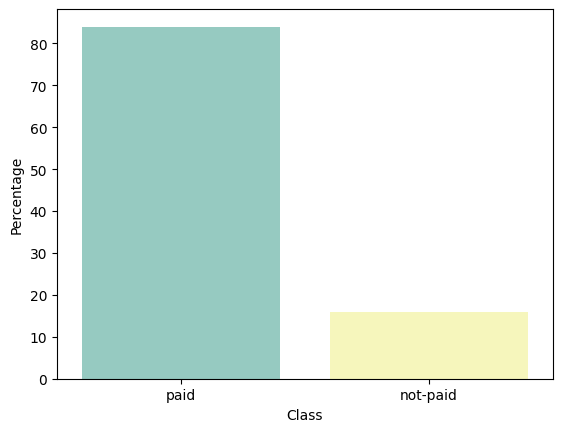

In [189]:
df_per={'Class':['paid','not-paid'],'Percentage':[paid_per,not_paid_per]}
df_percentage=pd.DataFrame(df_per)
print(df_percentage)
sns.barplot(x='Class',y='Percentage',data=df_percentage)

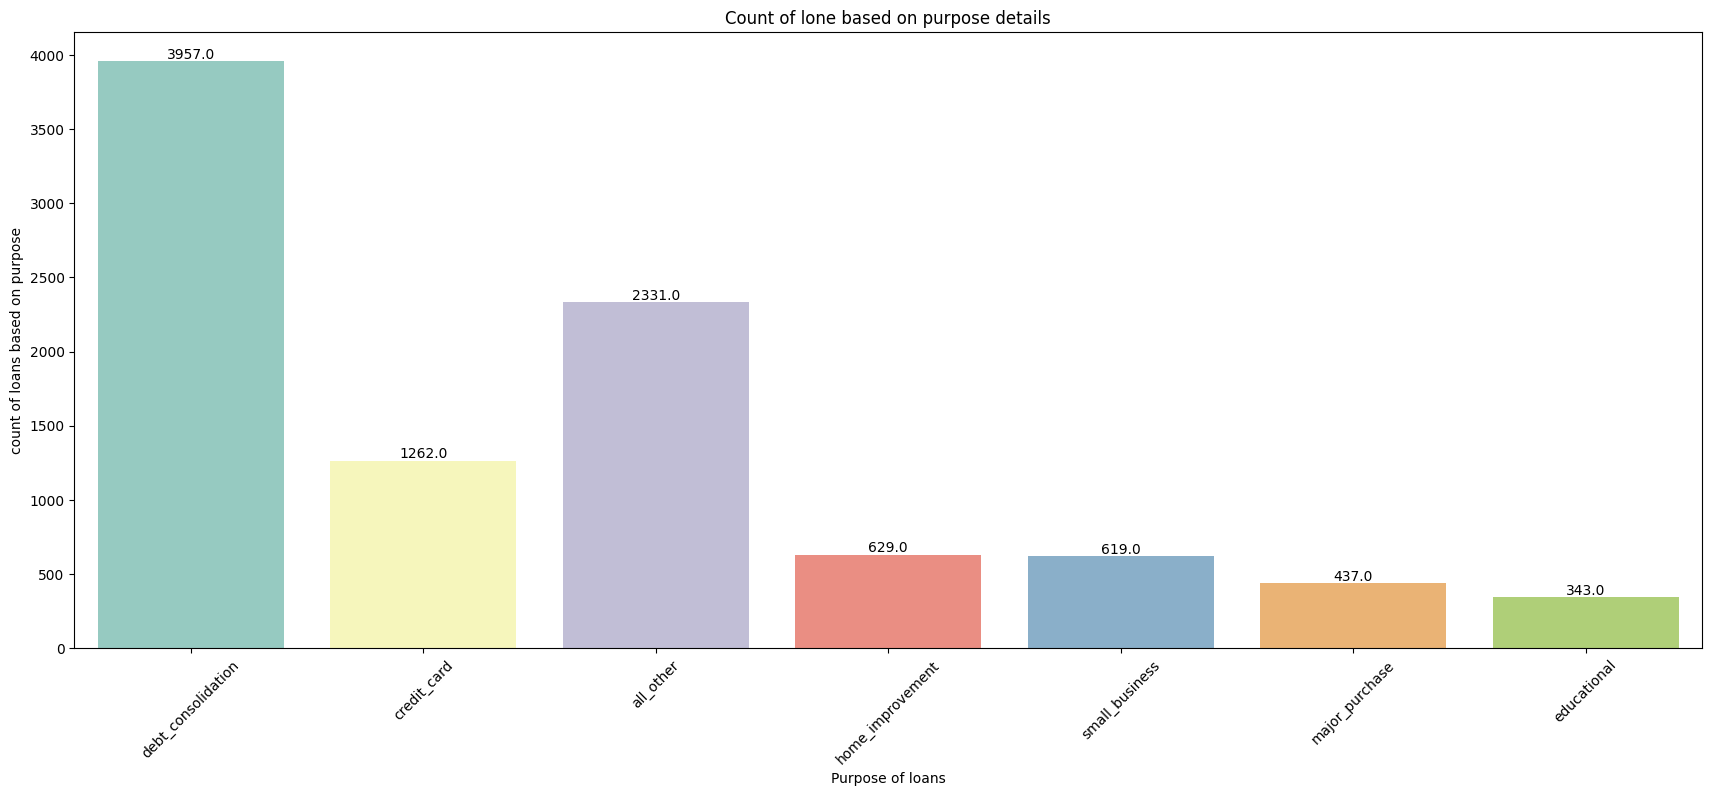

In [190]:
plt.figure(figsize=(21,8))
plot=sns.countplot(x='purpose',data=df)
plt.xticks(rotation=90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')
plt.xticks(rotation=45)
plt.title("Count of lone based on purpose details")
plt.xlabel('Purpose of loans')
plt.ylabel('count of loans based on purpose')
plt.show()

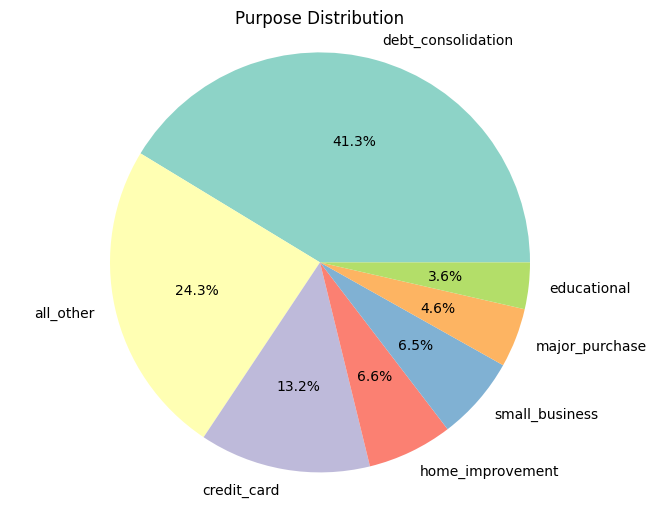

In [191]:
import seaborn as sns
purpose_counts = df['purpose'].value_counts()
plt.figure(figsize=(8, 6))
sns.set_palette("Set3") 
plt.pie(purpose_counts, labels=purpose_counts.index, autopct='%1.1f%%')
plt.axis('equal')  
plt.title('Purpose Distribution')
plt.show()


In [192]:
dummies =pd.get_dummies(df['purpose'],prefix='purpose')
df=pd.concat([df,dummies],axis=1)


In [193]:
df = df.drop('purpose', axis=1)
df

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1,1,0,0,0,0,0,0
9574,0,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1,1,0,0,0,0,0,0
9575,0,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1,0,0,1,0,0,0,0
9576,0,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1,0,0,0,0,1,0,0


## Is there a correlation between installment	,log.annual.inc,	dti,	fico	,days.with.cr.line,	revol.bal,	revol.util,	inq.last.6mths,	delinq.2yrs,	pub.rec   over not.paid.fully?

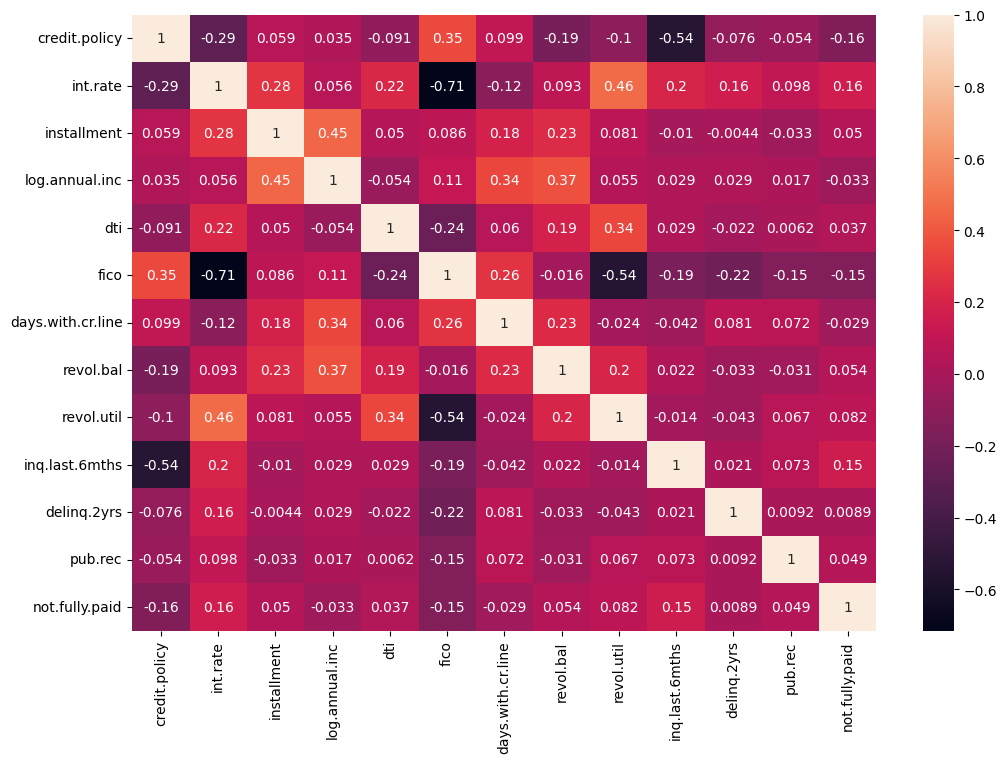

In [194]:
correlation=df_corr.corr()
correlation
plt.figure(figsize=(12,8))
plot=sns.heatmap(correlation,annot=True)
plt.show()

In [195]:
df_corr

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


# What are the top two factors  for not paid fully?

In [196]:
failed_corr=correlation['not.fully.paid']
sorted_corr=failed_corr.sort_values(ascending=False)
top_factors=sorted_corr[1:4]
print(f'top factors for loan not fully paid :')
print(top_factors)

top factors for loan not fully paid :
int.rate          0.159552
inq.last.6mths    0.149452
revol.util        0.082088
Name: not.fully.paid, dtype: float64


We can show that top most factors for unable to repay loan by customers is actually interest rate and inq of last 6 monts.

# For which  Purposes of loans are likely to be not paid in Future?


In [197]:
for feature in df.columns:
  if np.any(np.isnan(df[feature])):
    df["is_" + feature + "_missing"] = np.isnan(df[feature]) * 1
    print(feature)

In [212]:

X = df.drop('not.fully.paid', axis=1)
y = df['not.fully.paid']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [215]:
y_train.shape

(7662,)

In [217]:

print(f"Original data shapes: {X_train.shape, X_test.shape}")

print(f"Original data shapes: {y_train.shape, y_test.shape}")

Original data shapes: ((7662, 19), (1916, 19))
Original data shapes: ((7662,), (1916,))


In [218]:
scalar=StandardScaler()

In [220]:
X_train=scalar.fit_transform(X_train)
X_test=scalar.fit_transform(X_test)


In [221]:
model=keras.Sequential([
    keras.layers.Dense(256,activation="relu",input_shape=[19]),

    keras.layers.Dense(256,activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256,activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1,activation="sigmoid"),

]
    
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               5120      
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 136,961
Trainable params: 136,961
Non-tr

In [225]:
model.compile(optimizer='Adam',
               loss="binary_crossentropy",
               metrics=['binary_accuracy'])

In [226]:
early_stopping = keras.callbacks.EarlyStopping(patience = 10, min_delta = 0.001, 
                                               restore_best_weights =True )

In [229]:
history=model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    batch_size=256,
    epochs=100,
    callbacks=[early_stopping],
    verbose=1, 
)

Epoch 1/100
30/30 [==============================] - 0s 16ms/step - loss: 0.4075 - binary_accuracy: 0.8406 - val_loss: 0.4016 - val_binary_accuracy: 0.8408
Epoch 2/100
30/30 [==============================] - 0s 14ms/step - loss: 0.4070 - binary_accuracy: 0.8403 - val_loss: 0.4027 - val_binary_accuracy: 0.8398
Epoch 3/100
30/30 [==============================] - 0s 15ms/step - loss: 0.4040 - binary_accuracy: 0.8406 - val_loss: 0.4044 - val_binary_accuracy: 0.8403
Epoch 4/100
30/30 [==============================] - 0s 14ms/step - loss: 0.3993 - binary_accuracy: 0.8425 - val_loss: 0.4033 - val_binary_accuracy: 0.8413
Epoch 5/100
30/30 [==============================] - 0s 14ms/step - loss: 0.3973 - binary_accuracy: 0.8435 - val_loss: 0.4068 - val_binary_accuracy: 0.8392
Epoch 6/100
30/30 [==============================] - 0s 14ms/step - loss: 0.3931 - binary_accuracy: 0.8442 - val_loss: 0.4121 - val_binary_accuracy: 0.8408
Epoch 7/100
30/30 [==============================] - 0s 15ms/ste

In [230]:
predictions =(model.predict(X_test)>0.5).astype("int32")
              
predictions

60/60 [==============================] - 0s 2ms/step


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [231]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
accuracy_score(y_test, predictions)

0.8408141962421712

In [232]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1611
           1       0.50      0.01      0.03       305

    accuracy                           0.84      1916
   macro avg       0.67      0.51      0.47      1916
weighted avg       0.79      0.84      0.77      1916



<Axes: >

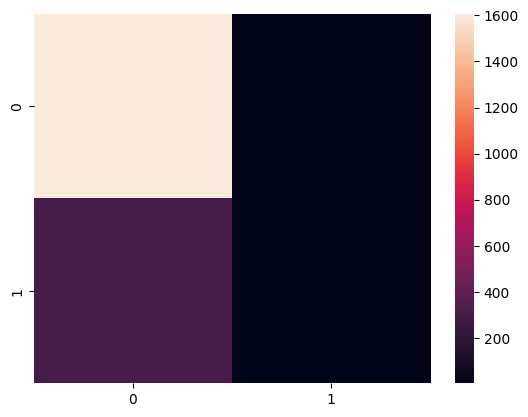

In [233]:
cn=confusion_matrix(y_test, predictions)
sns.heatmap(cn)

In [234]:
# Build random forest classifier
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")

In [235]:
rf_clf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=0.25, n_estimators=500)

In [236]:
y_preds=rf_clf.predict(X_test)

In [238]:
rf_clf.score(X_test,y_test)

0.8418580375782881

In [241]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1611
           1       0.67      0.01      0.03       305

    accuracy                           0.84      1916
   macro avg       0.75      0.51      0.47      1916
weighted avg       0.81      0.84      0.77      1916



In [242]:
print(confusion_matrix(y_test,y_preds))

[[1609    2]
 [ 301    4]]
